In [1]:
import os
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.reconst.dti as dti
import h5py

base_dir = "/storage"
base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in os.listdir(base_dir + "/HCP_7T") if len(i) == 6]
base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in os.listdir(base_dir + "/HCP_3T") if len(i) == 6]

path_7t = {}
path_3t = {}



for i in base_dir_7t:
    path_7t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.05.nii.gz" ,"data" : i + "/T1w/Diffusion_7T/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion_7T/bvals" , "bvecs" : i + "/T1w/Diffusion_7T/bvecs"
                      , "brain_mask" : i + "/T1w/Diffusion_7T/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion_7T/grad_dev.nii.gz"}
for i in base_dir_3t:
    path_3t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.25.nii.gz" , "data" : i + "/T1w/Diffusion/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion/bvals" , "bvecs" : i + "/T1w/Diffusion/bvecs"
                       , "brain_mask" : i + "/T1w/Diffusion/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion/grad_dev.nii.gz"}
    
    
path = {'3T': path_3t, "7T": path_7t}
p = list(path_7t.keys())
q = list(path_3t.keys())
common = list(set(p) & set(q))
common.sort()
print("number of common Subjects ",len(common))

def get_ids():
    return common

def load_hcp(id_load,res,crop = 1):
    load_from = path[res][id_load]
    data , affine = load_nifti(load_from["data"])
    mask,affine = load_nifti(load_from["brain_mask"])
    
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    gtab = gradient_table(bvals, bvecs)
    
    return data[:,:,:,:],mask[:,:,:],gtab

def load_gtab(id_load,res):
    load_from = path[res][id_load]
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    gtab = gradient_table(bvals, bvecs)
    return gtab

number of common Subjects  171


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy.linalg import inv
from numpy.linalg import pinv
# from numpy.linalg import lstsq
from scipy.linalg import lstsq
from numpy.linalg import solve
from numpy import inf
import numpy as np

import SimpleITK as sitk


dsm = np.array([0.91, 0.416, 0,0, 0.91, 0.416,0.416, 0, 0.91,0.91, -0.416, 0,0, 0.91, -0.416,-0.416, 0, 0.91])
dsm = dsm.reshape(6,3)
dsm_norm = np.copy(dsm)
dsm_mag = np.sqrt(dsm[:,0]**2 + dsm[:,1]**2 + dsm[:,2]**2)
for i in range(3):
    dsm_norm[:,i] = dsm[:,i] / dsm_mag

def rot3d(arg):
    x,y,z = arg[0],arg[1],arg[2]
    Rx = np.array([[1 ,0 ,0 ],[0,np.cos(x),-np.sin(x)],[0 ,np.sin(x) ,np.cos(x)]])
    Ry = np.array([[np.cos(y),0 ,np.sin(y) ],[0,1,0],[-np.sin(y),0,np.cos(y)]])
    Rz = np.array([[np.cos(z) ,-np.sin(z) ,0 ],[np.sin(z),np.cos(z),0],[0 ,0,1]])
    R = Rx @ Ry @ Rz
    return R

def amatrix(mat):
    
    a = [mat[:,0] * mat[:,0],2 * mat[:,0] * mat[:,1], 2* mat[:,0] * mat[:,2],
        mat[:,1] * mat[:,1],2 * mat[:,1] * mat[:,2], mat[:,2] * mat[:,2]]
    return np.array(a).T

def optimal_dirs(gtab,num_iter,num_dirs,debug = False,base_bval = 5):
    rotang_all = []
    angerr_all  = []
    condnum_all = []
    ind_all = []
    dirs = np.array(gtab.bvecs[np.where(gtab.bvals != base_bval)[0]])
    for i in range(0,num_iter):
        
        d = np.random.rand(1,3) * 2 * np.pi
        rotang = d[0]
        R = rot3d(rotang)
        dsm_rot = (rot3d(d[0]) @ dsm_norm.T).T
        
        ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))
        minerrors,idx = np.amin(ang_error,1),np.argmin(ang_error,1)

        mean_ang_err = np.mean(np.amin(ang_error,1))
        condnum = np.linalg.cond(amatrix(dirs[idx]))
        
        idx.sort()
        if (mean_ang_err < 5 and condnum < 1.6):
            if ((len(ind_all) == 0 ) or  len(np.where((ind_all == idx).all(axis=1))[0]) == 0 ):
                angerr_all.append(mean_ang_err)
                condnum_all.append(condnum)
                ind_all.append(idx)
                rotang_all.append(rotang)
    condnum_all = np.array(condnum_all)
    indx  = condnum_all.argsort()[:num_dirs]
    if (debug):
        print("Lowest Condition Number : ",condnum_all[indx])
    ind_use = np.array(ind_all)[indx]
    condnum_use = condnum_all[condnum_all.argsort()[:5]]
    angerr_use = np.array(angerr_all)[indx]
    rotang_use = np.array(rotang_all)[indx]
    return ind_use,condnum_all[indx]
# import numpy as np
def resample_img(itk_image, out_spacing,sampler = 'bspline'):
    
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if sampler == 'bspline':
        resample.SetInterpolator(sitk.sitkBSpline)
    elif sampler == 'nearneighbour':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkLinear)

    return resample.Execute(itk_image)

def resampler(data_sitk,idx,b0,upscale = False):
    resampled_sitk_img = []
    if(upscale == True):
        resampled_img = resample_img(data_sitk[:,:,:,int(b0)], out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
        resampled_sitk_img.append(sitk.GetArrayFromImage(resampled_img))
        for i in idx:
            resampled_img = resample_img(data_sitk[:,:,:,int(i)], out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
            resampled_sitk_img.append(sitk.GetArrayFromImage(resampled_img))
    else:
        resampled_sitk_img.append(sitk.GetArrayFromImage(data_sitk[:,:,:,int(b0)]))
        for i in idx:
            resampled_sitk_img.append(sitk.GetArrayFromImage(data_sitk[:,:,:,int(i)]))
    return np.stack(resampled_sitk_img, axis=3)

In [6]:
limited_common = common[:10]

In [7]:
limited_common

['100610',
 '102311',
 '102816',
 '104416',
 '105923',
 '108323',
 '109123',
 '111312',
 '111514',
 '114823']

In [8]:
shape_file = {}
shape_file_7t = {}

## 3T dump

In [16]:
upscale = False
for i in limited_common:
    
    print("Current ID",i)
    
    gtab = load_gtab(i,'3T')
    
    data_sitk = sitk.ReadImage(path['3T'][i]['data'])
    mask_sitk = sitk.ReadImage(path['3T'][i]['brain_mask'])
    if(upscale == True):
        name = "/storage/HCP_3T/" + i + "/" + i + "_upsampled.h5"
    else:
        name = "/storage/HCP_3T/" + i + "/" + i + ".h5"
        
    hf = h5py.File(name, 'w')
    
    idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))
    
    idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]
    
    for j in range(3):
        sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
        sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]
        
        bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
        bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)
        data6 = resampler(data_sitk,idx[j],sample,upscale = upscale)
        
        hf.create_dataset('volumes'+ str(j), data=np.transpose(data6, (2,1,0,3)))
        hf.create_dataset('bvals'+ str(j), data=bvals6)
        hf.create_dataset('bvecs'+ str(j), data=bvecs6)
    
    hf.create_dataset('idx', data=idx)
    hf.create_dataset('cond', data=cond)
    if(upscale == True):
        mask = resample_img(mask_sitk, out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
    else:
        mask = mask_sitk
    hf.create_dataset('mask', data=np.transpose(sitk.GetArrayFromImage(mask), (2,1,0)))
    
    hf.close()
    
    print(name,"Done")
    
#     name = "/storage/HCP_3T/" + i + "/" + i + "_GT.h5"
#     hf = h5py.File(name, 'w')
    
#     tenmodel = dti.TensorModel(gtab)
#     tenfit = tenmodel.fit(data,mask=mask)
#     tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
#     FA = fractional_anisotropy(tenfit.evals)
#     MD = dti.mean_diffusivity(tenfit.evals)
#     FA[np.isnan(FA)] = 0
#     FA = np.clip(FA, 0, 1)
#     RGB = color_fa(FA, tenfit.evecs)
    
#     hf.create_dataset('tensor_vals', data=tensor_vals)
#     hf.create_dataset('ADC', data=MD)
#     hf.create_dataset('FA', data=FA)
#     hf.create_dataset('color_FA', data=RGB)
    
#     hf.close()
#     print(name,"Done")

#     break

Current ID 100610


/tmp/ipykernel_444574/2051646578.py:53: RuntimeWarning: invalid value encountered in arccos
  ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))


Lowest Condition Number :  [1.41846062 1.42228552 1.42797114 1.44724113 1.44961196]
/storage/HCP_3T/100610/100610.h5 Done
Current ID 102311
Lowest Condition Number :  [1.42013738 1.43240749 1.43492422 1.44878411 1.4493136 ]
/storage/HCP_3T/102311/102311.h5 Done


In [ ]:
upscale = True
for i in limited_common:
    
    print("Current ID",i)
    
    gtab = load_gtab(i,'3T')
    
    data_sitk = sitk.ReadImage(path['3T'][i]['data'])
    mask_sitk = sitk.ReadImage(path['3T'][i]['brain_mask'])
    
    if(upscale == True):
        name = "/storage/HCP_3T/" + i + "/" + i + "_upsampled.h5"
    
    else:
        name = "/storage/HCP_3T/" + i + "/" + i + ".h5" 
    
    hf = h5py.File(name, 'w')
    
    idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))
    
    idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]
    
    for j in range(3):
        sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
        sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]
        
        bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
        bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)
        data6 = resampler(data_sitk,idx[j],sample,upscale = upscale)
        
        hf.create_dataset('volumes'+ str(j), data=np.transpose(data6, (2,1,0,3)))
        hf.create_dataset('bvals'+ str(j), data=bvals6)
        hf.create_dataset('bvecs'+ str(j), data=bvecs6)
    
    hf.create_dataset('idx', data=idx)
    hf.create_dataset('cond', data=cond)
    if(upscale == True):
        mask = resample_img(mask_sitk, out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
    else:
        mask = mask_sitk
    hf.create_dataset('mask', data=np.transpose(sitk.GetArrayFromImage(mask), (2,1,0)))
    
    hf.close()
    
    print(name,"Done")
    
#     name = "/storage/HCP_3T/" + i + "/" + i + "_GT.h5"
#     hf = h5py.File(name, 'w')
    
#     tenmodel = dti.TensorModel(gtab)
#     tenfit = tenmodel.fit(data,mask=mask)
#     tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
#     FA = fractional_anisotropy(tenfit.evals)
#     MD = dti.mean_diffusivity(tenfit.evals)
#     FA[np.isnan(FA)] = 0
#     FA = np.clip(FA, 0, 1)
#     RGB = color_fa(FA, tenfit.evecs)
    
#     hf.create_dataset('tensor_vals', data=tensor_vals)
#     hf.create_dataset('ADC', data=MD)
#     hf.create_dataset('FA', data=FA)
#     hf.create_dataset('color_FA', data=RGB)
    
#     hf.close()
#     print(name,"Done")

#     break

Current ID 201515
Lowest Condition Number :  [1.41550337 1.43008514 1.43280596 1.43789777 1.44156501]
/storage/HCP_3T/201515/201515_upsampled.h5 Done
Current ID 203418


/tmp/ipykernel_11801/1350378518.py:53: RuntimeWarning: invalid value encountered in arccos
  ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))


Lowest Condition Number :  [1.4243524  1.42932078 1.43325279 1.43745209 1.44217211]
/storage/HCP_3T/203418/203418_upsampled.h5 Done
Current ID 204521
Lowest Condition Number :  [1.40819005 1.41929671 1.4218599  1.42807757 1.42889973]
/storage/HCP_3T/204521/204521_upsampled.h5 Done
Current ID 205220
Lowest Condition Number :  [1.42653309 1.44678571 1.44727283 1.44750191 1.451668  ]
/storage/HCP_3T/205220/205220_upsampled.h5 Done
Current ID 209228
Lowest Condition Number :  [1.41296011 1.4274228  1.42986362 1.43830479 1.44456753]
/storage/HCP_3T/209228/209228_upsampled.h5 Done
Current ID 212419
Lowest Condition Number :  [1.43102026 1.4361996  1.43719451 1.44014962 1.44540801]
/storage/HCP_3T/212419/212419_upsampled.h5 Done
Current ID 214019
Lowest Condition Number :  [1.40569524 1.41937889 1.42631283 1.43071357 1.43518844]
/storage/HCP_3T/214019/214019_upsampled.h5 Done
Current ID 214524
Lowest Condition Number :  [1.40241576 1.41297102 1.41384553 1.42831424 1.45304267]
/storage/HCP_3T/

Lowest Condition Number :  [1.4204802  1.42717744 1.42783697 1.4300664  1.4327684 ]
/storage/HCP_3T/725751/725751_upsampled.h5 Done
Current ID 732243
Lowest Condition Number :  [1.45189549 1.462786   1.46794476 1.47262984 1.47550284]
/storage/HCP_3T/732243/732243_upsampled.h5 Done
Current ID 751550
Lowest Condition Number :  [1.41323527 1.42964619 1.43382053 1.43970557 1.44189471]
/storage/HCP_3T/751550/751550_upsampled.h5 Done
Current ID 757764
Lowest Condition Number :  [1.40311101 1.418077   1.42500573 1.43926519 1.44489982]
/storage/HCP_3T/757764/757764_upsampled.h5 Done
Current ID 765864
Lowest Condition Number :  [1.38844874 1.39378367 1.40666621 1.41620558 1.43001732]
/storage/HCP_3T/765864/765864_upsampled.h5 Done
Current ID 770352


In [ ]:
hf.close()

## 7T Dump

In [ ]:
for i in limited_common:
    print("Current ID",i)
    data,mask,gtab = load_hcp(i,'7T')
    name = "/storage/HCP_7T/" + i + "/" + i + ".h5"
    shape_file_7t[i] = data.shape
    
#     hf = h5py.File(name, 'w')
#     temp = data[:,:,:,gtab.bvals>5]
#     idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))
#     base_bvals_vols = data[:,:,:,gtab.bvals==int(min(gtab.bvals))]
#     base_bvals = gtab.bvecs[gtab.bvals==int(min(gtab.bvals)),:],gtab.bvals[gtab.bvals==int(min(gtab.bvals))]
#     dw_bvals = gtab.bvecs[gtab.bvals!=int(min(gtab.bvals)),:],gtab.bvals[gtab.bvals!=int(min(gtab.bvals))]
#     for j in range(3):
#         sample = np.random.randint(0,base_bvals_vols.shape[3])
#         b0 = base_bvals_vols[:,:,:,sample]
#         bvals6 = np.insert(dw_bvals[1][idx[j]],0,base_bvals[1][sample])
#         bvecs6 = np.insert(dw_bvals[0][idx[j]],0,base_bvals[0][sample],axis = 0)
#         data6 = temp[:,:,:,idx[j]]
#         data6 = np.insert(data6,0,b0,axis =3)
#         hf.create_dataset('volumes'+ str(j), data=data6)
#         hf.create_dataset('bvals'+ str(j), data=bvals6)
#         hf.create_dataset('bvecs'+ str(j), data=bvecs6)
#     hf.create_dataset('idx', data=idx)
#     hf.create_dataset('cond', data=cond)
#     hf.create_dataset('mask', data=mask)
    
#     hf.close()
#     print(name,"Done")
    
    name = "/storage/HCP_7T/" + i + "/" + i + "_GT.h5"
    hf = h5py.File(name, 'w')
    
    tenmodel = dti.TensorModel(gtab)
    maskdata, mask = median_otsu(data, vol_idx=range(0, data.shape[-1]),autocrop=False, dilate=2)
    tenfit = tenmodel.fit(data,mask=mask)
    tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
    FA = fractional_anisotropy(tenfit.evals)
    MD = dti.mean_diffusivity(tenfit.evals)
    FA[np.isnan(FA)] = 0
    FA = np.clip(FA, 0, 1)
    RGB = color_fa(FA, tenfit.evecs)
    
    hf.create_dataset('tensor_vals', data=tensor_vals)
    hf.create_dataset('ADC', data=MD)
    hf.create_dataset('FA', data=FA)
    hf.create_dataset('color_FA', data=RGB)
    
    hf.close()
    print(name,"Done")

In [4]:
import os
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.reconst.dti as dti
import h5py

In [26]:
curr_id = common[9]
name = "/storage/HCP_7T/" + curr_id + "/" + curr_id + "_GT.h5"
hf = h5py.File(name, 'r')
name = "/storage/HCP_3T/" + curr_id + "/" + curr_id + ".h5"
hf_lr = h5py.File(name, 'r')

In [27]:
name

'/storage/HCP_3T/114823/114823.h5'

In [28]:
import numpy as np

In [29]:
for i in list(hf_lr.keys()):
    print(i,np.array(hf_lr.get(i)).shape)

bvals0 (7,)
bvals1 (7,)
bvals2 (7,)
bvecs0 (7, 3)
bvecs1 (7, 3)
bvecs2 (7, 3)
cond (5,)
idx (5, 6)
mask (145, 174, 143)
volumes0 (145, 174, 143, 7)
volumes1 (145, 174, 143, 7)
volumes2 (145, 174, 143, 7)


In [30]:
for i in list(hf.keys()):
    print(i,np.array(hf.get(i)).shape)

ADC (173, 207, 173)
FA (173, 207, 173)
color_FA (173, 207, 173, 3)
tensor_vals (173, 207, 173, 6)


In [43]:
adc = np.array(hf.get('ADC'))

In [44]:
adc.shape

(173, 207, 173)

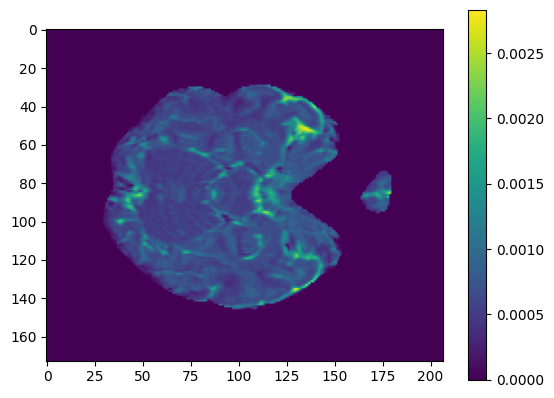

In [45]:
plt.imshow(adc[:,:,50])
plt.colorbar()

In [9]:
np.array(hf.get('idx'))

array([[  0,   1,   7,  12,  91, 106],
       [ 17,  37,  88,  91, 125, 134],
       [  4,  47,  72,  90,  93,  97],
       [  1,  37,  88,  91, 125, 134],
       [ 55,  62,  67,  69, 109, 134]])

In [36]:
np.array(hf.get('bvals0'))

array([  55.,   65.,  980., 1000.,  990., 1965., 2000.])

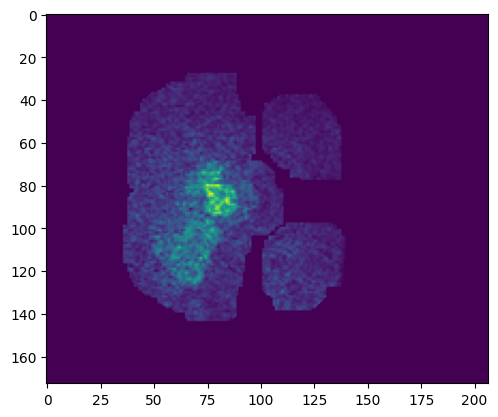

In [19]:
plt.imshow(np.array(hf.get('volumes0'))[:,:,20,6])

In [21]:
for i in list(hf_lr.keys()):
    print(i,np.array(hf_lr.get(i)).shape)

bvals0 (7,)
bvals1 (7,)
bvals2 (7,)
bvecs0 (7, 3)
bvecs1 (7, 3)
bvecs2 (7, 3)
cond (5,)
idx (5, 6)
mask (145, 174, 145)
volumes0 (145, 174, 145, 7)
volumes1 (145, 174, 145, 7)
volumes2 (145, 174, 145, 7)


In [34]:
np.array(hf_lr.get('bvals0'))

array([   5.,  990., 1000., 1005., 1000., 2985., 1995.])

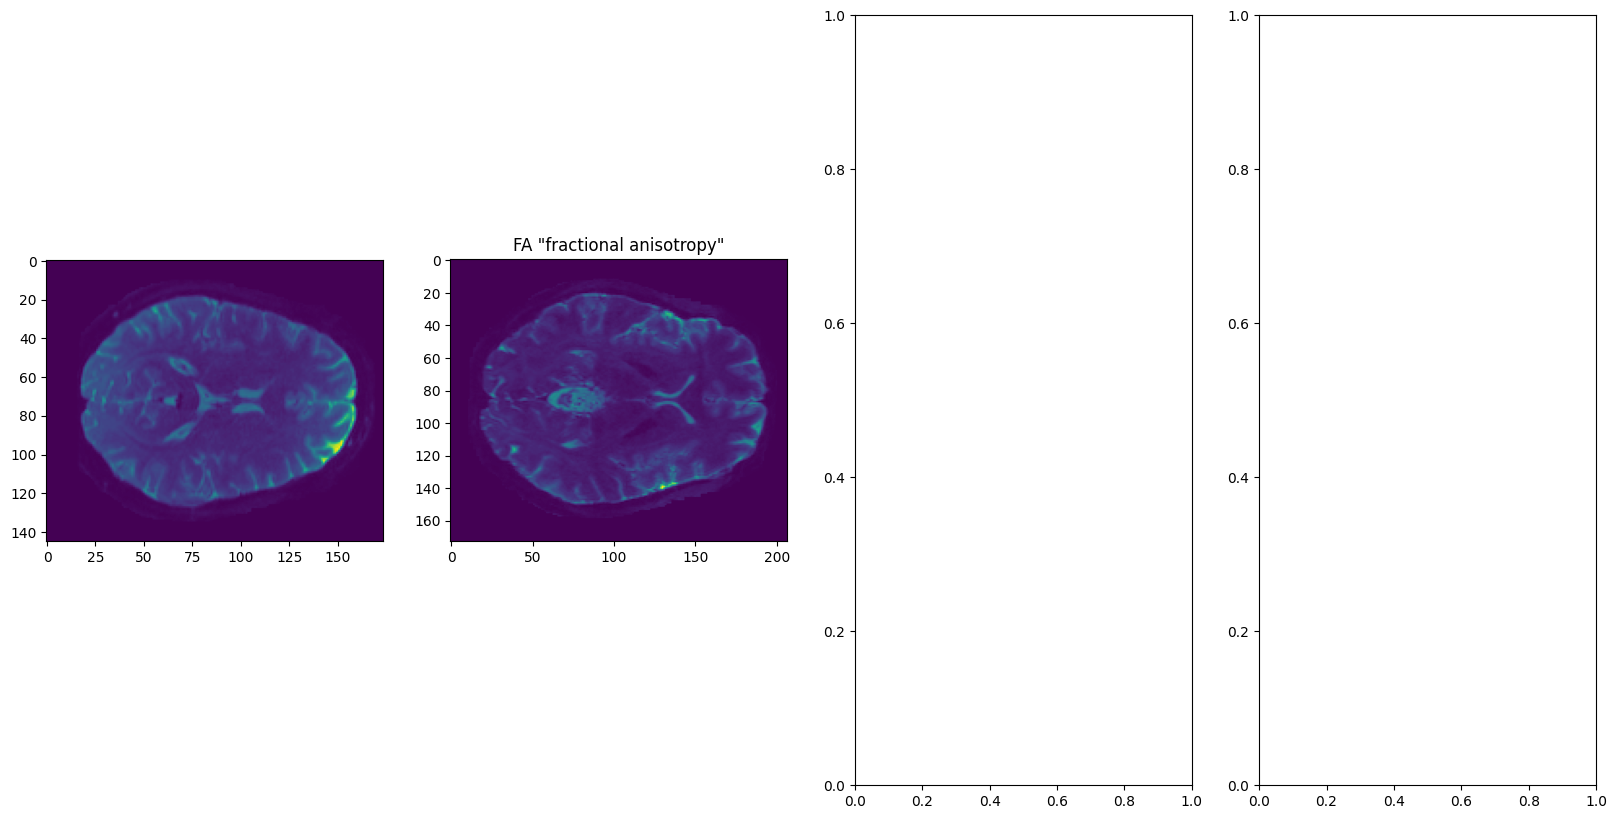

In [24]:
i=70
f, axis = plt.subplots(1, 4)
f.set_figwidth(20)
f.set_figheight(10)
temp = np.transpose(hf_lr.get('mask'), (2,1,0))
# temp = np.fliplr(np.rot90(hf_lr.get('volumes0')[i,:,:,0],k=3))
axis[0].imshow(hf_lr.get('volumes0')[:,:,i,0])
axis[1].set_title('FA "fractional anisotropy"')
axis[1].imshow(np.array(hf.get('volumes0'))[:,:,i,0])
# axis[2].set_title('MD "Mean Diffusivity or Average Diffusion Coefficent(ADC)"')
# axis[2].imshow(np.array(hf.get('ADC'))[:,:,i])
# axis[3].set_title('MD_RGB "Principal Diffusion Directions"')
# axis[3].imshow(np.array(hf.get('color_FA'))[:,:,i])

In [78]:
np.array(hf.get('ADC')).max(),np.array(hf.get('ADC')).min()

(0.08228759206068244, 0.0)

In [79]:
np.array(hf.get('FA')).max(),np.array(hf.get('FA')).min()

(0.9999997058573268, 0.0)

In [80]:
np.array(hf.get('color_FA')).max(),np.array(hf.get('color_FA')).min()

(0.9998092887740151, 0.0)

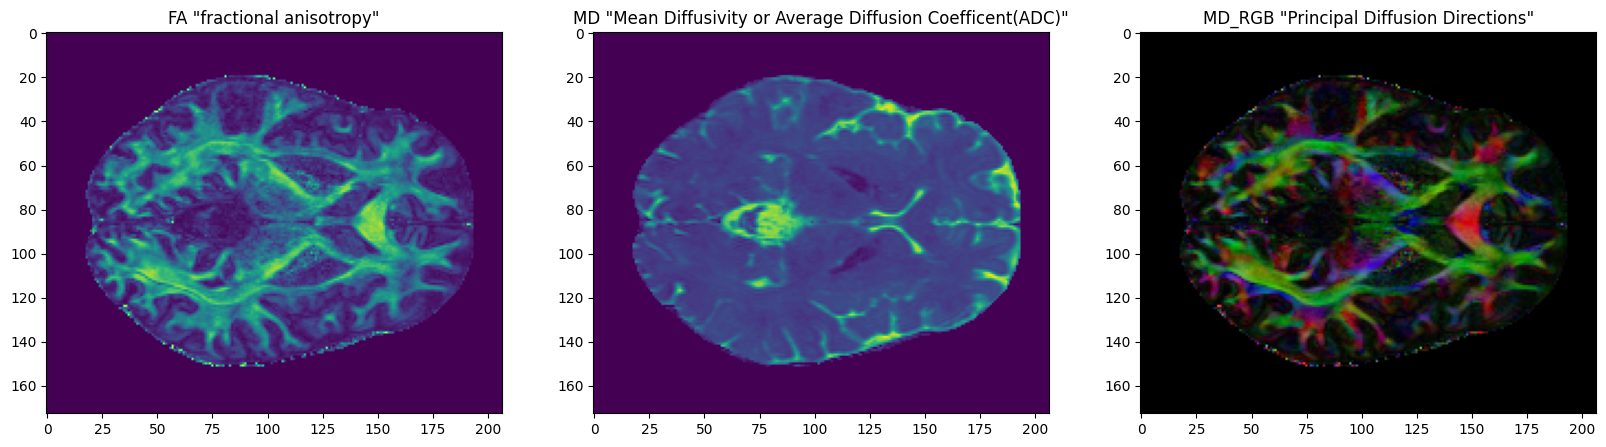

In [82]:
i=70
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].set_title('FA "fractional anisotropy"')
axis[0].imshow(np.array(hf.get('FA'))[:,:,i])
axis[1].set_title('MD "Mean Diffusivity or Average Diffusion Coefficent(ADC)"')
axis[1].imshow(np.array(hf.get('ADC'))[:,:,i])
axis[2].set_title('MD_RGB "Principal Diffusion Directions"')
axis[2].imshow(np.array(hf.get('color_FA'))[:,:,i])

In [1]:
# Make the corresponding MRtrix3 Python libraries available
import inspect, os, sys
LIB_FOLDER = os.path.realpath(os.path.join(os.path.dirname(os.path.realpath(inspect.getfile(inspect.currentframe()))), os.pardir, 'lib'))
if not os.path.isdir(LIB_FOLDER):
  sys.stderr.write('Unable to locate MRtrix3 Python libraries')
  sys.exit(1)
sys.path.insert(0, LIB_FOLDER)

Unable to locate MRtrix3 Python libraries

SystemExit: 1

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import 

'/tmp/lib'

In [4]:
sys.path.insert(0,"/root/miniconda3/bin/")

In [23]:
from mrtrix3 import path, run

In [25]:
run.command('mrconvert ' + ' ' + path.to_scratch('in.mif') + ' -strides 0,0,0,1')

Command:  mrconvert  /workspace/in.mif -strides 0,0,0,1


TypeError: expected str, bytes or os.PathLike object, not int

In [21]:
#!/usr/bin/env python

# this function sets up the command-line interface for the command
def usage(cmdline):
  cmdline.set_author('W. Heath Robinson (h.robinson@implausible.com)')
  cmdline.set_synopsis('Compute voxel-wise geometric mean across volumes')
  # command arguments and options
  cmdline.add_argument('input', help='an input image')
  cmdline.add_argument('output', help='the output image')
  cmdline.add_argument('-invalid', help='value if any intensity is non-positive (default = NaN)')
  # optional citation and non-default copyright statement
  cmdline.add_citation('Robinson, W.H. A treatise on geometric averaging. Contrived Science Weekly, 2019.')
  cmdline.set_copyright('Copyright (c) 2019 Heath Robinson Labs.')


# this function contains the primary operation of the command
def execute():
  from mrtrix3 import path, run
  # import data in temporary directory
  app.make_scratch_dir()
  run.command('mrconvert ' + path.from_user(app.ARGS.input) + ' ' + path.to_scratch('in.mif') + ' -strides 0,0,0,1')
  app.goto_scratch_dir()
  # primary command processing
  run.command('mrcalc in.mif -log log.mif')
  run.command('mrmath -axis 3 log.mif mean meanlog.mif')
  if app.ARGS.invalid:
    run.command('mrcalc meanlog.mif -exp NaN {} -replace out.mif'.format(app.ARGS.invalid))
  else:
    run.command('mrcalc meanlog.mif -exp out.mif')
  # copy to output
  run.command('mrconvert out.mif ' + path.from_user(app.ARGS.output))

# Execute the script
import mrtrix3
mrtrix3.execute()



AttributeError: module 'runpy' has no attribute 'usage'

In [11]:
import mrtrix3

In [19]:
dir(mrtrix3)

['ANSI',
 'ANSICodes',
 'BIN_PATH',
 'COMMAND_HISTORY_STRING',
 'CONFIG',
 'EXE_LIST',
 'MRtrixBaseError',
 'MRtrixError',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '__warningregistry__',
 '_version',
 'app',
 'arg',
 'config_path',
 'execute',
 'find_executable',
 'imp',
 'imported',
 'inspect',
 'namedtuple',
 'os',
 'quote',
 'run',
 'setup_ansi',
 'sys',
 'utils']

In [16]:
dir(mrtrix3.execute)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [17]:
mrtrix3.execute()

AttributeError: module 'runpy' has no attribute 'usage'

In [ ]:
dwi2tensor -fslgrad bvecs bvals data.nii.gz - | tensor2metric - -fa temp_adc.nii --force -info -mask nodif_brain_mask.nii.gz